# Tutorial de Pytorch 4: MNIST

https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

Este conjunto de datos está en formato numpy y se ha almacenado usando *pickle*, un formato específico de Python para serializar datos.

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        
# _ es el conjunto de test, que no vamos a usar.

Cada imagen es de 28 x 28 y se almacena como una fila de 784 de longitud (= 28x28). Para visualizarlo tendremos que cambiar su forma (*reshape*) a una matriz de 28 x 28.

(50000, 784)


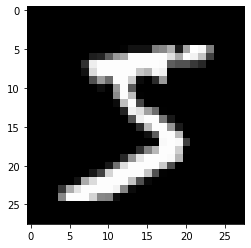

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch usa <code>torch.tensor</code>, en lugar de matrices numpy, por lo que necesitamos convertir nuestros datos.

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)  # Xavier initialisation 
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Gracias a la capacidad de **PyTorch** para calcular gradientes automáticamente, podemos usar cualquier función estándar de Python (u otro objeto invocable) como modelo. Así que vamos a crear un modelo simple mediante una multiplicación de matrices y una suma con *broadcasting*. También necesitamos una función de activación, así que crearemos la función *log_softmax*. Recuerda: aunque **PyTorch** proporciona muchas funciones de pérdida predefinidas, como funciones de activación, etc., puedes escribir fácilmente las tuyas propias usando Python simple. PyTorch incluso creará el código eficiente para la GPU o CPU.

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

$$  \text{softmax}(v)_j = \frac{e^{v_j}}{  \sum_{i=1}^k{e^{v_i}} }   $$

$$  \text{log softmax}(v)_j = \log( \frac{e^{v_j}}{  \sum_{i=1}^k{e^{v_i}} } )  = \log( e^{v_j}) - log({  \sum_{i=1}^k{e^{v_i}} } )  =  v_j - log({  \sum_{i=1}^k{e^{v_i}} } ) $$

En el código anterior, <code>@</code> representa la operación del **producto escalar**. Llamaremos a nuestra función con un *batch* (en este caso, 64 imágenes). Esta sería una ejecución hacia adelante (*forward*). Ten en cuenta que nuestras predicciones no serán mejores que las aleatorias en esta etapa, ya que comenzamos con pesos aleatorios.

<code>torch.unsqueeze</code> devuelve un nuevo tensor con una dimensión adicional en la posición especificada.

Ejemplo:

<code>
>>> x = torch.tensor([1, 2, 3, 4])
>>> torch.unsqueeze(x, 0)
tensor([[ 1,  2,  3,  4]])
>>> torch.unsqueeze(x, 1)
tensor([[ 1],
        [ 2],
        [ 3],
        [ 4]])
</code>

In [9]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions

print(preds[0], preds.shape)

tensor([-1.9524, -2.5958, -2.0874, -2.2833, -2.4667, -2.2969, -2.8356, -2.3140,
        -1.9733, -2.5833], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [11]:
def nll(input, target):  # negative log-likelihood
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Aclaración sobre el código anterior:

In [9]:
X = torch.tensor(np.array([[1.,2.,3.],[4.,5.,6.]]))

target = torch.tensor(np.array([1,0])).long()

print(X[range(target.shape[0]), target])  # es una forma de extraer solo los valores a los que apunta el target

tensor([2., 4.], dtype=torch.float64)


In [12]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3470, grad_fn=<NegBackward>)


También implementamos una función para calcular la precisión de nuestro modelo. Para cada predicción, si el índice con el mayor valor coincide con el valor objetivo, entonces la predicción fue correcta.

In [13]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [14]:
print(accuracy(preds, yb))

tensor(0.0938)


> Puedes usar el depurador de Python estándar para recorrer el código PyTorch, to que le permite verificar los distintos valores de las variables en cada paso. Descomenta set_trace() para probarlo.

In [17]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

n, c = x_train.shape

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [18]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0823, grad_fn=<NegBackward>) tensor(1.)


## Usando torch.nn.functional

In [19]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [20]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward>) tensor(1.)


In [21]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Dado que ahora estamos usando un objeto en lugar de solo usar una función, primero tenemos que crear una instancia de nuestro modelo:

In [32]:
model = Mnist_Logistic()

In [27]:
print(loss_func(model(xb), yb))

tensor(2.4429, grad_fn=<NllLossBackward>)


In [28]:
print(bias.grad)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [29]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [34]:
print(model.parameters())

<generator object Module.parameters at 0x0000021A15BC1748>


In [36]:
with torch.no_grad():
    for p in model.parameters(): 
        print(p.grad)
        p -= p.grad * lr
    model.zero_grad()

None


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [37]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [38]:
print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


## Refactorizando usando nn.Linear

Seguimos refactorizando nuestro código. En lugar de definir e inicializar manualmente <code>self.weights</code> y <code>self.bias</code>, y calcular <code>xb @ self.weights + self.bias</code>, usaremos la clase <code>vnn.Linear</code> de Pytorch para una capa lineal, que hace todo eso por nosotros. Pytorch tiene muchos tipos de capas predefinidas que pueden simplificar enormemente nuestro código y, a menudo, también lo hacen más rápido.

In [39]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [40]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2458, grad_fn=<NllLossBackward>)


In [41]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0826, grad_fn=<NllLossBackward>)


## Refactorizando usando optim

In [42]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3217, grad_fn=<NllLossBackward>)
tensor(0.0813, grad_fn=<NllLossBackward>)


## Refactorizando usando Dataset

In [28]:
class Cosas():
    def __init__(self):
        self.A = []
        
    def add(self, x):
        self.A.append(x)
    
    def __len__(self):
        return len(self.A)
    
    def __call__(self):
        return ("Tamaño: " + str(len(self.A)))
    
    def __getitem__(self, ix):
        return self.A[ix]
        
    
c = Cosas()

In [44]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [45]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


## Refactorizando usando DataLoader

In [46]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [51]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)
